In [ ]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression

### About this dataset

This data comes courtesy of OECD and shows historical population data broken down by sex and age for the 56 members of the OECD
The data includes population information from 1960 - 2020

Citation:

OECD (2021), "Labour Force Statistics: Historical population data", OECD Employment and Labour Market Statistics (database), https://doi.org/10.1787/4cf3d106-en (accessed on 21 October 2021).

In [ ]:
#import and clean dataset
pd.options.display.float_format = '{:,.2f}'.format
countries_data = pd.read_csv("raw_data/HISTPOP_21102021122126731.csv")
pop_data = countries_data.groupby(by=["Country", "Time", "Sex", "Age"]).sum().reset_index(drop=False)
pop_data = pop_data[pop_data.Age.str.contains(pat="^\w{1,2} to \w{1,4}$|85 and over|^Total$")]
Age_labels = pop_data.Age.unique().tolist()
Age_labels.insert(1, Age_labels.pop(11))
Age_labels.remove("15 to 64")
Age_labels.remove("20 to 64")
pop_data = pop_data[pop_data.Age.str.contains("|".join(Age_labels))]
pop_data.drop(columns=["TIME", "Flag Codes", "Flags"], inplace=True)
pop_data.rename({"Time": "Year", "Value": "Population"}, axis=1, inplace=True)
pop_data.sort_values(by=["Year", "Age", "Population"], inplace=True, ascending=True)
pop_data.reset_index(drop=True, inplace=True)



In [22]:
#create OECD class
class OECD():
  """
  use this class instance to find out more about the dataset
  """

  def list_countries(self):
    """
    Call this method to print the list of available countries    
    """
    print('Available countries from this dataset include:\n'+'\n'.join(pop_data.Country.unique()))

    return pop_data.Country.unique()
  
  def list_years(self):
    """
    Call this method to print the list of available countries    
    """
    years = pop_data.Year.astype('object').unique()
    years = [str(year) for year in years]
    print('Available years from this dataset include:\n'+'\n'.join(years))
    

#create country class 

class Country():
  """
  To create an instance of Country, call Country with the country name.
  """
  #seaborn styling
  sns.set_theme(context="talk", style='darkgrid', palette="bright")
  
  def __init__(self, name):
    self.name = name

  def country_pop_profile(self):
    """
    Returns a dataframe with population data for the country
    """
    country_data = pop_data[pop_data["Country"] == self.name].reset_index(drop=True)

    return country_data
  
  def chart_pop_growth(self, by_sex=False, as_line=False, years=''):
    """
    Plots total population over time, providing an idea of how numbers have changed
    By default plots 1960 - 2020. To view a subset of years add the argument years and the min and max year as a tuple with min year, max year and step between years (by default 5) (e.g. years=(2000, 2005, 2)). Note - setting the step only works when as_line = True
    Add the argument by_sex=True to see a breakdown by sex
    If a line chart is preferred add the argument as_line=True
    """
    #create the dataframe
    data = self.country_pop_profile()

    
    #check for years argument and set if not present
    if years:
      if len(years) != 3:
        year_step = 5
      else:
        year_step = years[2]
      data = data[data['Year'].isin([year for year in range(years[0], years[1]+1)])]
    else:
      year_step = 5
      years = (min(data.Year.values), max(data.Year.values))
      
    #create the fig and axis   
    fig, ax, = plt.subplots(figsize=(16,10))
    x_ticks = range(min(data.Year.unique()), max(data.Year.unique()+1), year_step)
    ax.ticklabel_format(style="plain", axis="y")
    ax.set_xlim(min(data.Year.unique()), max(data.Year.unique()))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels=x_ticks, rotation=90)
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    #check for sex argument
    if by_sex == False:
      total_pop = data[(data.Sex == "Total") & (data.Age == "Total")]
      min_pop = min(data.Population[(data.Sex == "Total") & (data.Age == "Total")]) * 0.98
      max_pop = max(data.Population[(data.Sex == "Total") & (data.Age == "Total")]) * 1.02
      if as_line == False:
        sns.barplot(data=total_pop, x="Year", y="Population", ax=ax)
      else:
        sns.lineplot(data=total_pop, x="Year", y="Population", ax=ax)
      ax.set_ylim(min_pop, max_pop)
      ax.set_title(f'{self.name} Population over time: {min(data.Year.values)} - {max(data.Year.values)}')
    elif by_sex == True:
      sex_pop = data[(data.Age == "Total")]
      if as_line == False:
        sns.barplot(data=sex_pop, x="Year", y="Population", hue="Sex", ax=ax)
      else:
        sns.lineplot(data=sex_pop, x="Year", y="Population", hue="Sex", ax=ax)
      
      ax.set_title(f'{self.name} Population over time by sex: {min(data.Year.values)} - {max(data.Year.values)}')
      ax.legend(bbox_to_anchor=(1,1))


    

    plt.show()

  def chart_pop_by_age(self, years=None, by_sex=False):
    """
    Plots barcharts for populations by age and sex for years 2005 - 2020
    If specific years are desired these can be included in a list as an argument (e.g. [2005, 2010, 2020])
    If a breakdown by sex is required, add the argument by_sex = True
    """
    data = self.country_pop_profile()

    if years != None:
      data = data[(data["Year"].isin(years)) & (~data["Age"].str.contains('Total')) & (data["Sex"] != 'Total')]
    else:
      data = data[(~data["Age"].str.contains('Total')) & (data["Sex"] != 'Total')]
    
    age_order = data.Age.unique().tolist()
    age_order.insert(1, age_order.pop(9))

    if by_sex == True:
      g = sns.catplot(kind="bar", data=data, x="Age", y="Population", hue="Sex", col="Year", col_wrap=3, height=5, aspect=1, order=age_order, sharex=False, sharey=False, palette="bright", legend=False)
      g.fig.suptitle(f"Population by Age & Sex - {self.name}", x=0, y=1, fontsize=16)
    else:
      g = sns.catplot(kind="bar", data=data, x="Age", y="Population", col="Year", col_wrap=3, height=8, aspect=1.2, order=age_order, sharex=False, sharey=False, palette="bright", ci=None)

    g.fig.suptitle(f"Population by Age - {self.name}", x=0, y=1, fontsize=16)
    g.set_titles("Population by Age for {col_name}")
    g.set_xticklabels(labels=age_order, rotation=90, ha='center')
    g.fig.tight_layout(pad=1, w_pad=4)

    for ax in g.axes:
      ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
      if by_sex == True:
        ax.legend()
      else:
        pass
    
    plt.show()

  def growth_trend(self, max_year=2050):
    """
    Plots linegraph of population over time with projections up to 2050.
    The length of projection can be set by setting the max_year argument to the value of your choice
    """
    data = self.country_pop_profile()
    totals = data[(data.Age == 'Total') & (data.Sex == 'Total')].reset_index(drop=True)
    totals.drop(['Sex', 'Age'], inplace=True, axis=1)

    X = totals.Year.values.reshape(-1,1)
    y = totals.Population.values

    reg = LinearRegression().fit(X,y)
    y_preds = reg.predict(X)
    X_future = np.array([x for x in range(2020, (max_year+1))]).reshape(-1,1)
    y_future = reg.predict(X_future)

    future_df = pd.DataFrame({'year': X_future.ravel(), 'predicted population': y_future.ravel()})
    df = pd.DataFrame({'year':X.ravel(), 'real population':y.ravel(), 'predicted population':y_preds.ravel()})

    
    
    melt = pd.melt(df, id_vars='year', var_name='real/pred', value_name='population')
    fig, ax = plt.subplots(figsize=(10,6))
    sns.lineplot(data=melt, x='year', y='population', style='real/pred', ax=ax, linewidth=2, alpha=0.4)
    sns.lineplot(data=future_df, x='year', y='predicted population', linestyle='dashed', label='future prediction', linewidth=2, alpha=0.4)
    ax.set_title(f'Population and Predicted Growth in {self.name} 2005 - {max_year}')
    plt.tight_layout()
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.legend(title='')
    ax.axvline(x=2020, color='black', linestyle='dotted')
    plt.show()

  def line_growth(self, years=''):
    data = self.country_pop_profile()

    if years:
      if len(years) != 3:
        year_step = 5
      else:
        year_step = years[2]
      
      data = data[data['Year'].isin([year for year in range(years[0], years[1]+1)])]
    else:
      year_step = 5
      years = (min(data.Year.values), max(data.Year.values))

    age_order = data.Age.unique().tolist()
    age_order.insert(1, age_order.pop(9))

    totals = data[(data.Sex == 'Total') & (data.Age != 'Total')]
    zero_to_thirty = totals[totals['Age'].isin(age_order[:5])].groupby(by="Year").sum()
    thirty_to_sixty = totals[totals['Age'].isin(age_order[6:11])].groupby(by="Year").sum()
    sixty_plus = totals[totals['Age'].isin(age_order[11:])].groupby(by="Year").sum()
    fig, ax = plt.subplots(figsize=(16, 10))
    x_ticks = range(min(data.Year.unique()), max(data.Year.unique()+1), year_step)
    sns.lineplot(data=zero_to_thirty, x='Year', y='Population', ci=None, label='Under 30')
    sns.lineplot(data=thirty_to_sixty, x='Year', y='Population', ci=None, label='30 - 59')
    sns.lineplot(data=sixty_plus, x='Year', y='Population', ci=None, label='Over 60')
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_title(f"Population by Age Group: {self.name} - 1960 - 2020")
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels=x_ticks, rotation=90)

    plt.legend()
    plt.show()
    

#create comparison class

class Compare_Countries():
  """
  Use this class to compare countries of your choosing (recommended limit to 4 for useful visualisations)
  """

  def __init__(self, *countries):
    self.countries = countries
  
  def get_countries_data(self):
    countries_data = []
    for country in self.countries:
      country_data = Country(country).country_pop_profile()
      countries_data.append(country_data)

    countries_data = pd.concat(countries_data, axis=0, ignore_index=True)
    return countries_data
  
  def compare_population_over_time(self):
    countries_data = self.get_countries_data()

    totals = countries_data[(countries_data["Sex"] == "Total") & (countries_data["Age"] == "Total")]
    fig, axs = plt.subplots(2,1, figsize=(12,10))
    fig.suptitle("Population Comparison over time 1960 - 2020", fontproperties={"weight":"bold", "size": "x-large", "family": "sans-serif"})
  


    for ax in fig.axes:
      ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    sns.lineplot(data=totals, x="Year", y="Population", hue="Country", ax=axs[1])
    axs[1].set_title("Total Population: {}".format(" vs. ".join([name for name in totals.Country.unique()])))
    axs[1].legend(bbox_to_anchor=(1,1), title="Country")


    sex_data = countries_data[(countries_data["Age"] == "Total") & (countries_data.Sex != "Total")]
    sns.lineplot(data=sex_data, x="Year", y="Population", style="Sex", hue="Country", ax=axs[0])
    axs[0].set_title("Population by Sex: {}".format(" vs. ".join([name for name in sex_data.Country.unique()])))
    axs[0].legend(bbox_to_anchor=(1,1))
    

    plt.tight_layout()
    plt.show()

  def compare_population_by_year(self, year):
    countries_data = self.get_countries_data()
    
    fig, axs = plt.subplots(1,2,figsize=(16,10), sharey=True)
    fig.suptitle("Population Comparison for {}\n{}".format(year, " vs. ".join([name for name in countries_data.Country.unique()])), fontproperties={"weight":"bold", "size": "large", "family": "sans-serif"})
    year_data = countries_data[(countries_data["Year"] == year)].reset_index(drop=True)
    
    #country by sex
    top_bar = year_data[(year_data.Age == "Total") & (year_data.Sex == "Total")].sort_values(by="Country")
    female_bar = year_data[(year_data.Age == "Total") & (year_data.Sex == "Women")].sort_values(by="Country")
    bar_1 = sns.barplot(data=top_bar, x="Country", y="Population", ci=None, color='#023eff', ax=axs[0])
    bar_2 = sns.barplot(data=female_bar, x="Country", y="Population", ci=None, color='#ff7c00', ax=axs[0])


    bar_1 = mpl.patches.Patch(color='#023eff', label="Male")
    bar_2 = mpl.patches.Patch(color='#ff7c00', label="Female")
    
    axs[0].legend(handles=[bar_1, bar_2], title="Sex")
    axs[0].set_title("Breakdown by Sex")

    #country by age
    age_order = year_data.Age.unique().tolist()
    age_order.insert(1, age_order.pop(9))

    totals = year_data[(year_data.Sex == 'Total') & (year_data.Age != 'Total')]
    zero_to_thirty_data = totals[totals['Age'].isin(age_order[:5])].groupby(by="Country").sum().reset_index()
    thirty_to_sixty_data = totals[totals['Age'].isin(age_order[:11])].groupby(by="Country").sum().reset_index()

    total_age_bar = sns.barplot(data=top_bar, x="Country", y="Population", color='#e8000b', ci=None, ax=axs[1])
    thirty_to_sixty_bar = sns.barplot(data=thirty_to_sixty_data, x="Country", y="Population", color='#00d7ff', ci=None, ax=axs[1])
    zero_to_thirty_bar = sns.barplot(data=zero_to_thirty_data, x="Country", y="Population", color='#ffc400', ci=None, ax=axs[1])

    total_age_bar = mpl.patches.Patch(color='#e8000b', label="60 and over")
    thirty_to_sixty_bar = mpl.patches.Patch(color='#00d7ff', label="30 to 60")
    zero_to_thirty_bar = mpl.patches.Patch(color='#ffc400', label = "Under 30")

    axs[1].legend(handles=[total_age_bar, thirty_to_sixty_bar, zero_to_thirty_bar], title="Age")
    axs[1].set_title("Breakdown by Age")
    axs[1].set_ylabel("")

    for ax in fig.axes:
      ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    plt.tight_layout()
    plt.show()





In [ ]:
#OECD().list_countries()

comparison = Compare_Countries("United Kingdom", "Lithuania")

comparison.compare_population_by_year(2010)

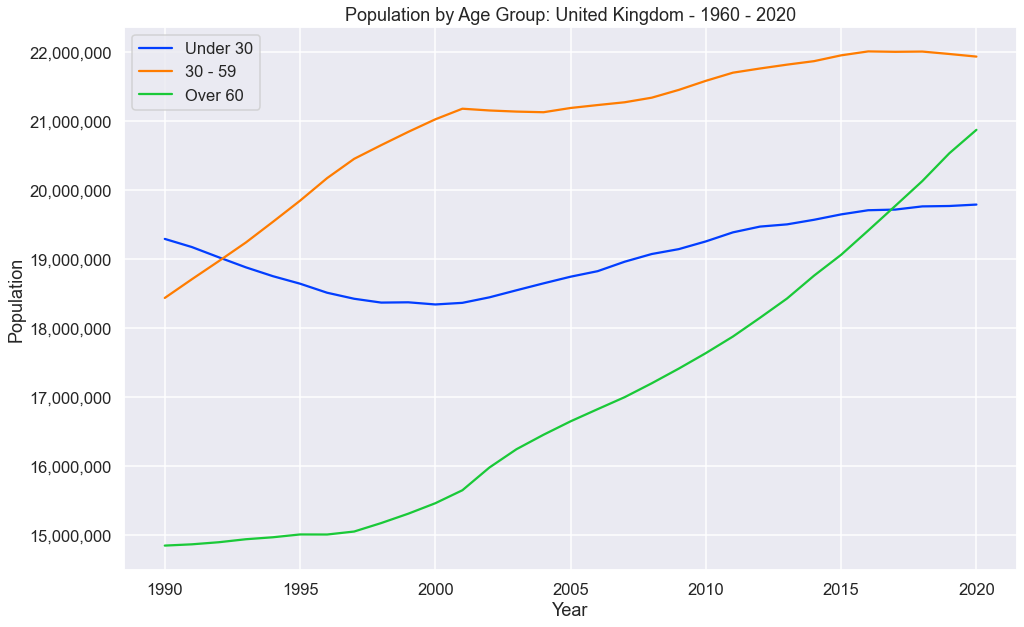

In [24]:
uk = Country("United Kingdom")

uk.line_growth(years=(1990,2020,5))